#  1. 트랜스포머와 비교할 때 변경이 필요한 부분

- 디코더 구조
    - (마스크된 셀프 어텐션 -> 피드포워드 -> 출력)
- 포지셔널 임베딩 층 수정
    - 위치 정보를 학습하도록 변경 
- 데이터 셋 변경
    - input, target 데이터셋 변경
- 인퍼런스 함수 변경
    - 기존 코드에서 모델 예측으로 코드 변경

# Step 0. 필요한 라이브러리 import

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Step 1. 데이터 수집하기

In [2]:
# CSV 파일 경로 설정
file_path = os.getenv('HOME')+"/aiffel/transformer_chatbot/data/ChatbotData.csv"

# Pandas를 이용해 CSV 파일 읽기
data = pd.read_csv(file_path)

# 데이터 출력
print(data.head())  # 데이터의 첫 5개 행을 출력

                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0


# Step 2. 데이터 전처리

데이터 정규화

In [3]:
# 전처리 함수
def preprocess_sentence(sentence):

    # 앞뒤 공백 제거
    sentence = sentence.strip()
    # 한글, 영어, 숫자, 구두점 외 제거
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9.,!? ]", " ", sentence)
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 다중 공백을 단일 공백으로
    sentence = re.sub(r"\s+", " ", sentence)
    
    # ㅋㅋ, ㅎㅎ, ㅠㅠ 등을 정규화
    sentence = re.sub(r'ㅋ{2,}', 'ㅋㅋ', sentence)  # 연속된 ㅋ를 ㅋㅋ로 통일
    sentence = re.sub(r'ㅎ{2,}', 'ㅎㅎ', sentence)  # 연속된 ㅎ를 ㅎㅎ로 통일
    sentence = re.sub(r'ㅠ{2,}', 'ㅠㅠ', sentence)  # 연속된 ㅠ를 ㅠㅠ로 통일

    return sentence

# 2. 모델의 입력 형태의 맞게 전처리 수행

- 아래 단어장 생성 부분 제외하고 7개 코드 수정

In [4]:
# 디코더만 사용하므로만 입력이 1개
# 전처리 후 clean_data로 합침

clean_data=[]

for x in data['Q']:
    clean_data.append(preprocess_sentence(x))
    
for x in data['A']:
    clean_data.append(preprocess_sentence(x))

In [5]:
print('Q와 A 샘플 합 :', len(data['Q'])+len(data['A']))
print('전처리된 데이터셋 :', len(clean_data))

Q와 A 샘플 합 : 23646
전처리된 데이터셋 : 23646


단어장(Vocabulary) 생성

In [6]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(clean_data, target_vocab_size=2**13)

In [7]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [8]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8168]
END_TOKEN의 번호 : [8169]


In [9]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2

# Step 3. SubwordTextEncoder 사용

각 단어를 고유한 정수로 인코딩(Integer encoding)

In [10]:
# 길이 분포 출력
data_len = [len(s.split()) for s in clean_data]

print('전처리된 데이터셋의 최소 길이 : {}'.format(np.min(data_len)))
print('전처리된 데이터셋의 최대 길이 : {}'.format(np.max(data_len)))
print('전처리된 데이터셋의 평균 길이 : {}'.format(np.mean(data_len)))

전처리된 데이터셋의 최소 길이 : 1
전처리된 데이터셋의 최대 길이 : 24
전처리된 데이터셋의 평균 길이 : 4.3285545123911024


In [11]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 24

In [12]:
# 디코더만 사용하므로만 입력이 1개

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs):
    
    tokenized_inputs = []

    for sentence in inputs:
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence = START_TOKEN + tokenizer.encode(sentence) + END_TOKEN

        # 최대 길이 24이하인 경우에만 데이터셋으로 허용
        if len(sentence) <= MAX_LENGTH:
            tokenized_inputs.append(sentence)

    # 최대 길이 24로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs

In [13]:
input_data = tokenize_and_filter(clean_data)

print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 input 데이터셋 개수: {}'.format(len(input_data)))

단어장의 크기 : 8170
필터링 후의 input 데이터셋 개수: 23638


교사 강요(Teacher Forcing) 사용

In [14]:
# 디코더만 사용하므로 input_data를 사용해 교사 강요 사용

BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
        input_data[:, :-1],
        input_data[:, 1:]
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


# Step 4. 모델 구성

트랜스포머 구성에 필요한 함수들 구현

# 3. 모델의 입력 블럭을 GPT 논문에 기반해 수정

- 포지셔널 인코딩 레이어 수정
- 인코딩 레이어 삭제
- 디코딩 레이어 수정
- 트랜스포머 정의 함수 수정

In [15]:
# 기존 고정된 포지셔널 인코딩 방식을 학습 가능한 포지셔널 인코딩 방식으로 변경

# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        # self.pos_encoding = self.positional_encoding(position, d_model)
        self.pos_encoding = self.add_weight("pos_encoding", shape=[1, position, d_model], initializer=tf.initializers.RandomNormal(), trainable=True)
    '''
    def get_angles(self, position, i, d_model):
      angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
      return position * angles

    def positional_encoding(self, position, d_model):
      # 각도 배열 생성
      angle_rads = self.get_angles(
          position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
          i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
          d_model=d_model)

      # 배열의 짝수 인덱스에는 sin 함수 적용
      sines = tf.math.sin(angle_rads[:, 0::2])
      # 배열의 홀수 인덱스에는 cosine 함수 적용
      cosines = tf.math.cos(angle_rads[:, 1::2])

      # sin과 cosine이 교차되도록 재배열
      pos_encoding = tf.stack([sines, cosines], axis=0)
      pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
      pos_encoding = tf.reshape(pos_encoding, [position, d_model])

      pos_encoding = pos_encoding[tf.newaxis, ...]
      return tf.cast(pos_encoding, tf.float32)
      '''
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [16]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

In [17]:
# 멀티헤드 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
    
        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)
    
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        
        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query,batch_size)
        key = self.split_heads(key,batch_size)
        value = self.split_heads(value,batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

In [18]:
# 마스크 패딩
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

# 룩 어헤드 마스킹(Look-ahead masking)
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [19]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    # enc_outputs 사용 X
    # enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)
    
    # 인코더-디코더 어텐션 사용 X
    '''
    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)
    '''
    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
                                        # 인코더-디코더 어텐션 사용하지 않으므로 attention1 사용
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention1)
                                # 인코더-디코더 어텐션 사용하지 않으므로 attention1 사용

    return tf.keras.Model(
        inputs=[inputs, look_ahead_mask, padding_mask],
                    # enc_outputs 사용 X
        outputs=outputs,
        name=name)

In [20]:
# 디코더 정의 함수
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    # enc_outputs 사용 X
    # enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, look_ahead_mask, padding_mask])
                        # enc_outputs 사용 X

    return tf.keras.Model(
        inputs=[inputs, look_ahead_mask, padding_mask],
                        # enc_outputs 사용 X
        outputs=outputs,
        name=name)

In [21]:
# 디코더만 사용하므로만 입력이 1개

# 트랜스포머 모델 정의 함수
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs_x")
    # enc_outputs 사용 X
    # enc_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")
    
    # 인코딩 사용 X
    '''
    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)
    '''
    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(inputs)
    
    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)
    
    # 인코딩 사용 X
    '''
    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])
    '''
    
    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, look_ahead_mask, dec_padding_mask])
            # enc_outputs 사용 X

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

트랜스포머 모델 정의

# 4. GPT 모델을 정상적으로 구성

In [22]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 디코더의 층의 개수
D_MODEL = 256 # 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_x (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           inputs_x[0][0]                   
__________________________________________________________________________________________________
dec_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs_x[0][0]                   
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 256)    5237248     inputs_x[0][0]                   
                                                                 look_ahead_mask[0][0]  

모델 summary()

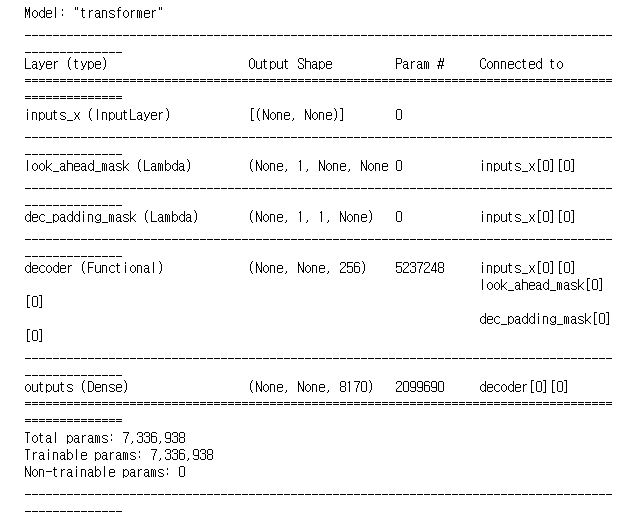

손실 함수 정의

In [23]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    # 레이블인 시퀀스에 패딩이 되어 있어, loss를 계산할 때 패딩 마스크를 적용
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

커스텀 된 학습률 정의

l
r
a
t
e
=
d
−
0.5
m
o
d
e
l
⋅
m
i
n
(
s
t
e
p
_
n
u
m
−
0.5
,
s
t
e
p
_
n
u
m
⋅
w
a
r
m
u
p
_
s
t
e
p
s
−
1.5
)

In [24]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

모델 컴파일

In [25]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

모델 훈련

In [26]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
370/370 [==============================] - 14s 27ms/step - loss: 2.2844 - accuracy: 0.0400
Epoch 2/50
370/370 [==============================] - 10s 27ms/step - loss: 1.8234 - accuracy: 0.0647
Epoch 3/50
370/370 [==============================] - 10s 27ms/step - loss: 1.6523 - accuracy: 0.0744
Epoch 4/50
370/370 [==============================] - 10s 27ms/step - loss: 1.5058 - accuracy: 0.0832
Epoch 5/50
370/370 [==============================] - 10s 28ms/step - loss: 1.3609 - accuracy: 0.0938
Epoch 6/50
370/370 [==============================] - 10s 28ms/step - loss: 1.2174 - accuracy: 0.1049
Epoch 7/50
370/370 [==============================] - 10s 28ms/step - loss: 1.0839 - accuracy: 0.1166
Epoch 8/50
370/370 [==============================] - 10s 28ms/step - loss: 0.9686 - accuracy: 0.1283
Epoch 9/50
370/370 [==============================] - 10s 28ms/step - loss: 0.8739 - accuracy: 0.1399
Epoch 10/50
370/370 [==============================] - 10s 28ms/step - loss: 0.800

model.fit 결과
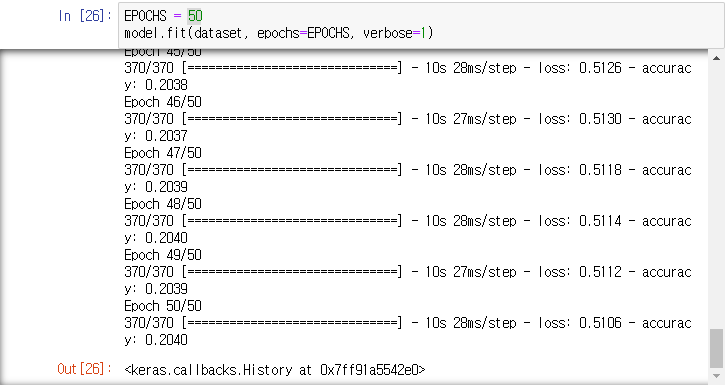

# Step 5. 모델 평가하기

In [27]:
# 디코더만 사용하므로 코드 수정

def decoder_inference(sentence):
    
    sentence = preprocess_sentence(sentence)
    
    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    
    # 사용 X
    '''
    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
    '''
    
    # 주어진 문장으로 모델 예측
    prediction = model.predict(sentence)

    # 예측된 확률 배열에서 가장 큰 값을 가지는 인덱스를 선택합니다.
    predicted_indices = tf.argmax(prediction, axis=-1).numpy().flatten()

    return predicted_indices

In [28]:
def sentence_generation(sentence):
    
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

# 5. 입력에 따른 출력 생성

In [29]:
sentence_generation('내말이 우스워?')

입력 : 내말이 우스워?
출력 : 좋아하는 가안돼통해질거 싫어


'좋아하는 가안돼통해질거 싫어'

In [30]:
sentence_generation('피곤하다ㅠ')

입력 : 피곤하다ㅠ
출력 : 좋아하는 하게 네요


'좋아하는 하게 네요'

In [31]:
sentence_generation('오늘은 flex 해버렸지 뭐야')

입력 : 오늘은 flex 해버렸지 뭐야
출력 : 좋아하는 또 �야인데 이 좋아하는 다않아도  ? 그냥 


'좋아하는 또 �야인데 이 좋아하는 다않아도  ? 그냥 '

In [32]:
sentence_generation('드라이브 조지고 싶다 ㅠㅠㅠ')

입력 : 드라이브 조지고 싶다 ㅠㅠㅠ
출력 : 좋아하는 하면서 �싶어들을 


'좋아하는 하면서 �싶어들을 '

In [33]:
sentence_generation('자고싶어')

입력 : 자고싶어
출력 : 좋아하는  ? 있으면 


'좋아하는  ? 있으면 '